In [29]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# Reset rcparams
plt.rcdefaults()

# Specify the directory path
directory = "../../logs/Reddit-troll"
table = []
seed_data = {}

# Iterate over all .json files in the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".json"):
            # Get the file path
            file_path = os.path.join(root, file)
            
            # Load the data from the .json file
            with open(file_path, "r") as f:
                data = json.load(f)
            
            # Extract the necessary information
            seed = os.path.basename(root)
            feature_size = os.path.basename(os.path.dirname(root))
            model = os.path.basename(os.path.dirname(os.path.dirname(root)))
            dataset = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(root))))
            train_aucs = data["train_aucs"]
            val_aucs = data["val_aucs"]
            test_aucs = data["test_aucs"]
            best_test_auc = data["test_auc"]
            time_per_epoch = data["time_per_epoch"]
            epochs = data["epoch"]
            table.append([model, feature_size, seed, best_test_auc, time_per_epoch, epochs])
            name = f"{dataset}-{model}-{feature_size}"
            if name not in seed_data:
                seed_data[name] = {}
            seed_data[name][seed] = {"train_aucs": train_aucs, "val_aucs": val_aucs, "test_aucs": test_aucs, "model": model, "feature_size": feature_size, "seed": seed, "best_test_auc": best_test_auc, "time_per_epoch": time_per_epoch, "epochs": epochs}

Reddit-troll-GCN-8


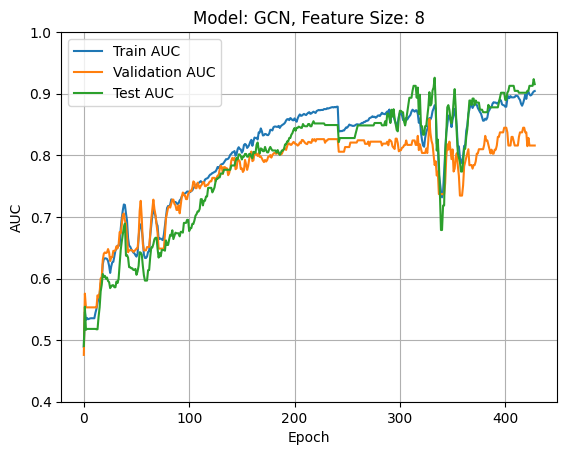

Reddit-troll-GCN-16


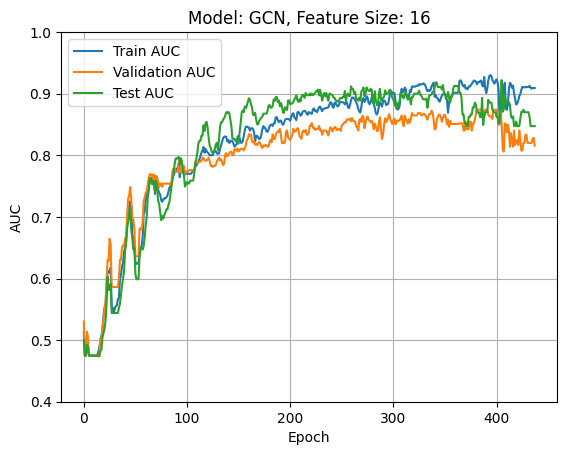

Reddit-troll-GCN-32


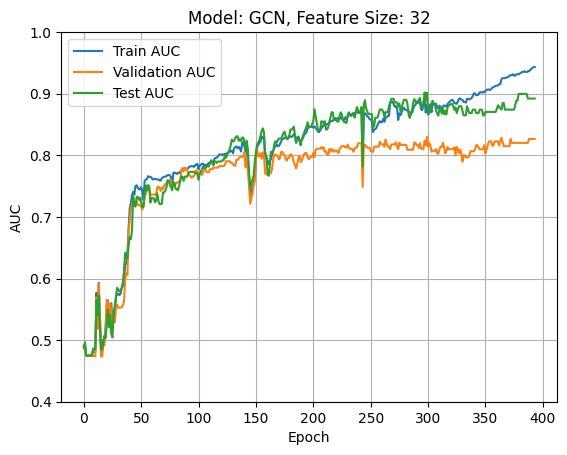

Reddit-troll-GAT-8


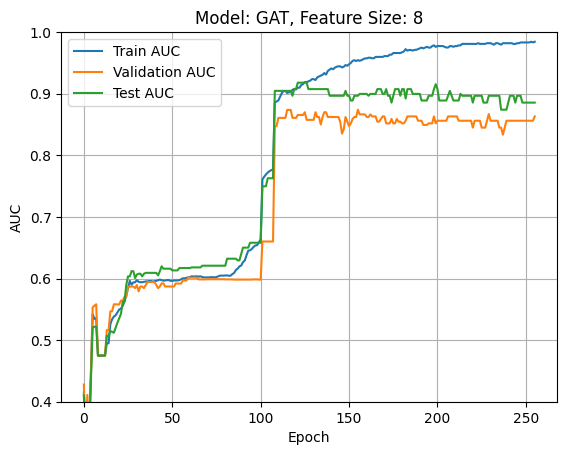

Reddit-troll-GAT-16


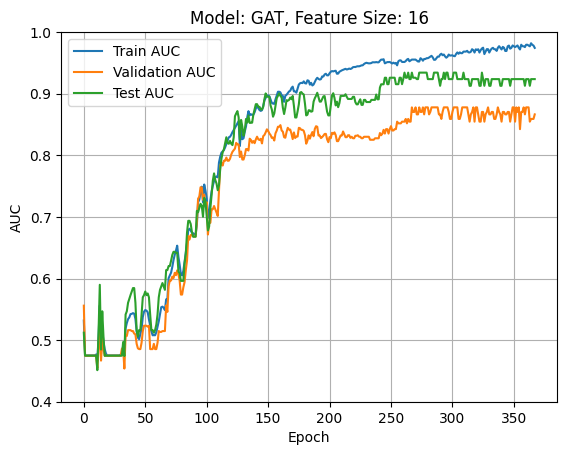

Reddit-troll-GAT-32


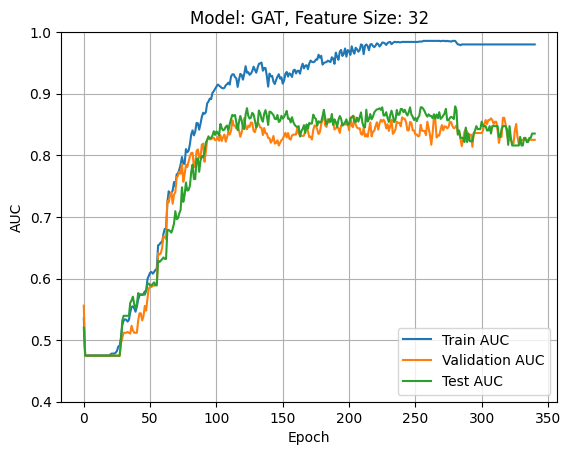

Reddit-troll-RGCN-8


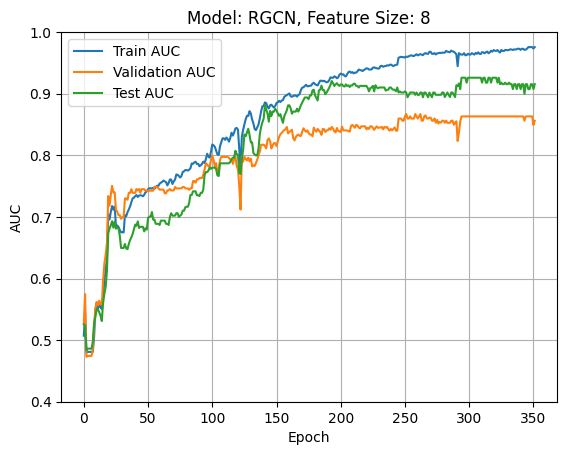

Reddit-troll-RGCN-16


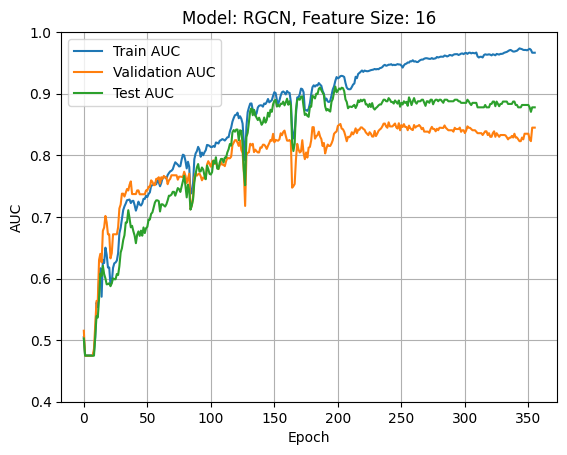

Reddit-troll-RGCN-32


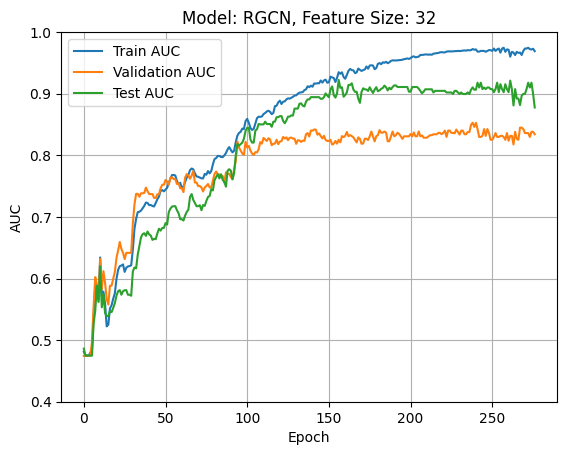

Reddit-troll-HGT-8


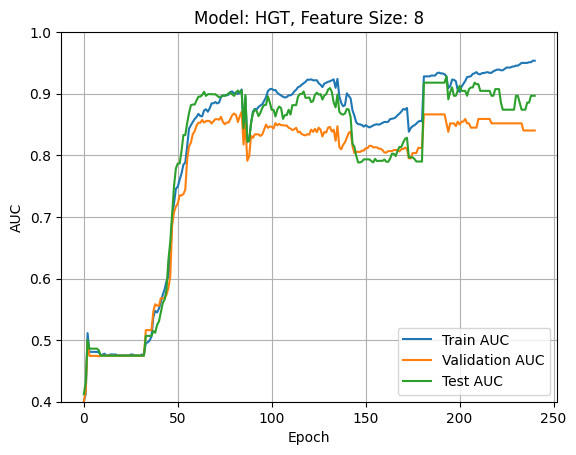

Reddit-troll-HGT-16


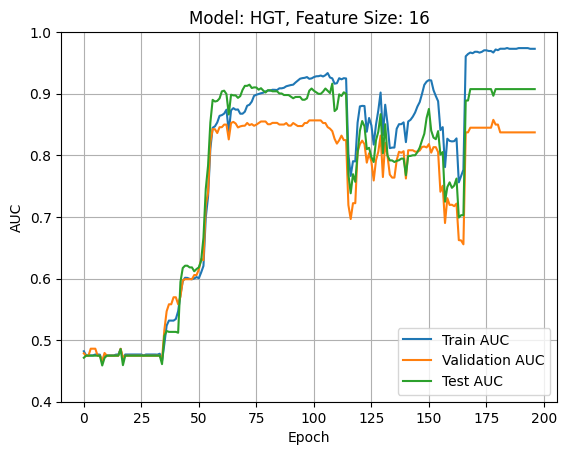

Reddit-troll-HGT-32


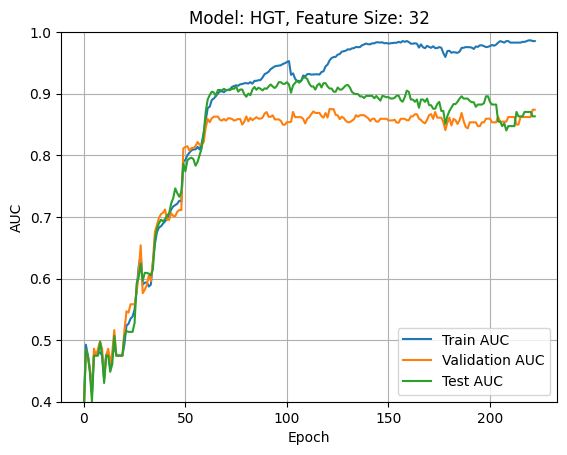

Reddit-troll-HTGNN-8


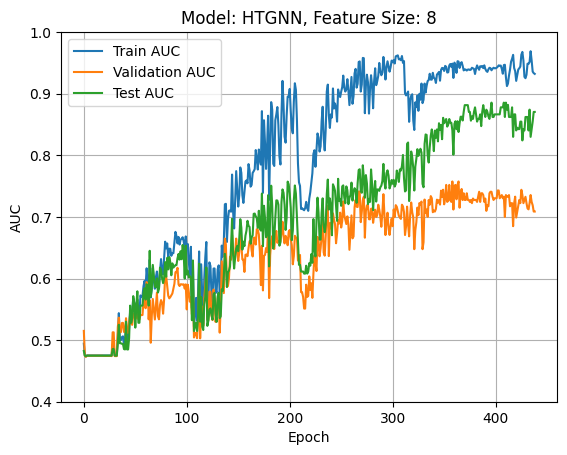

Reddit-troll-HTGNN-16


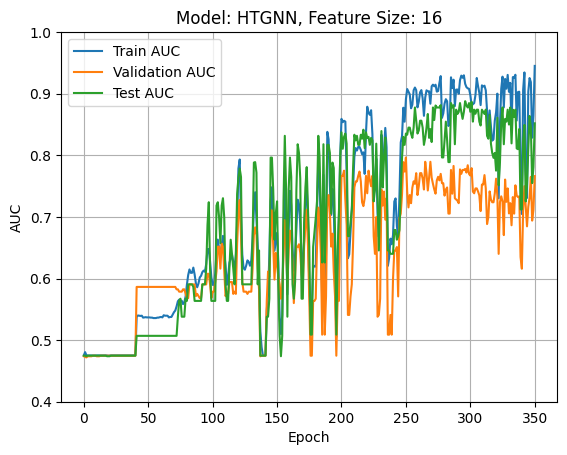

Reddit-troll-HTGNN-32


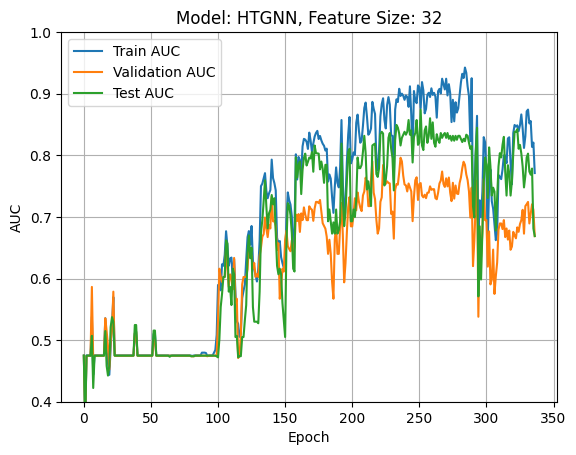

Reddit-troll-LSTM-8


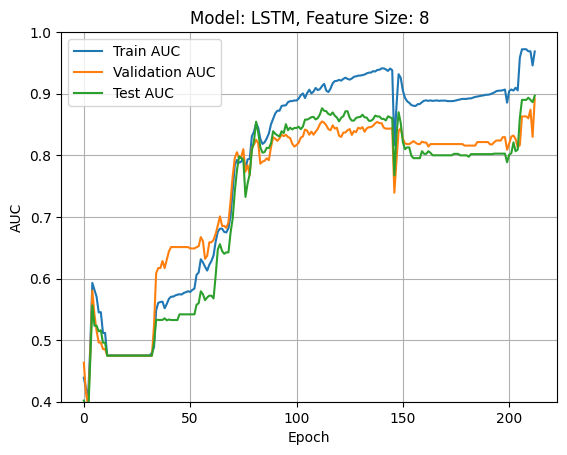

Reddit-troll-LSTM-16


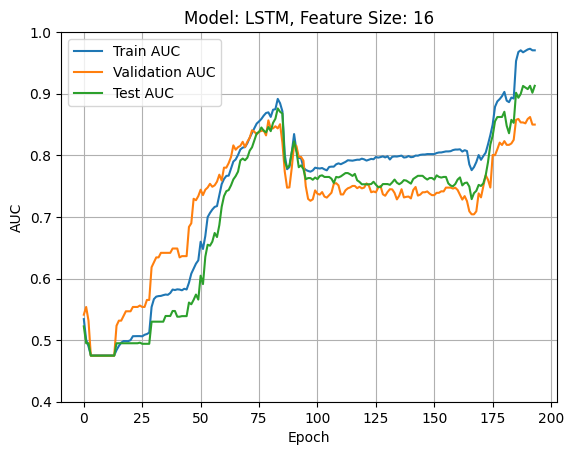

Reddit-troll-LSTM-32


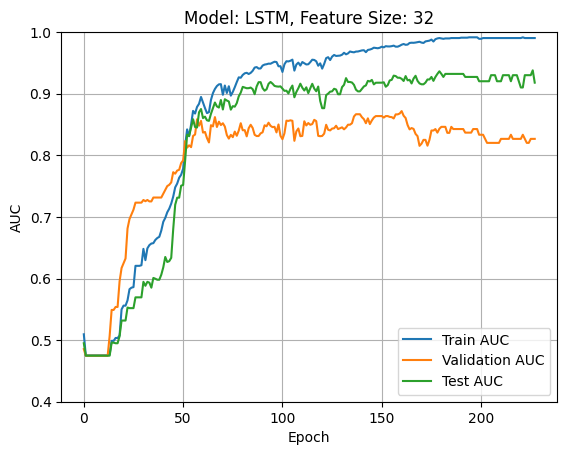

TypeError: agg function failed [how->mean,dtype->object]

In [31]:
for name, val in seed_data.items():
    print(name)
    train_aucs = []
    val_aucs = []
    test_aucs = []
    for seed, data in val.items():
        train_aucs.append(data["train_aucs"])
        val_aucs.append(data["val_aucs"])
        test_aucs.append(data["test_aucs"])
    model = val[list(val.keys())[0]]["model"]
    feature_size = val[list(val.keys())[0]]["feature_size"]
    # Calculate average of each list of lists.
    # If lists are of different size, only average remaining elements.
    def avg_variable_size_lists(lists):
        max_len = max([len(l) for l in lists])
        return np.mean(np.ma.masked_invalid([l + [np.nan] * (max_len - len(l)) for l in lists]), axis=0)
    train_aucs = avg_variable_size_lists(train_aucs)
    val_aucs = avg_variable_size_lists(val_aucs)
    test_aucs = avg_variable_size_lists(test_aucs)
    plt.plot(range(len(train_aucs)), train_aucs, label="Train AUC")
    plt.plot(range(len(val_aucs)), val_aucs, label="Validation AUC")
    plt.plot(range(len(test_aucs)), test_aucs, label="Test AUC")
    
    # Set the plot title and labels
    plt.title(f"Model: {model}, Feature Size: {feature_size}")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    
    # Add a legend
    plt.legend()

    # Add gridlines
    plt.grid(True)
    
    plt.ylim(0.4, 1.0)

    # Save in ../plots/Reddit-troll
    plot_path = os.path.join("../../plots/Reddit-troll", f"{dataset}-{model}-{feature_size}")
    plt.savefig(plot_path + ".png", dpi=300)
    # Save as pdf
    plt.savefig(plot_path + ".pdf")
    
    # Show the plot
    plt.show()

In [44]:
# Output table to csv
import pandas as pd
df = pd.DataFrame(table, columns=["Model", "Feature Size", "Seed", "Test AUC", "Time Per Epoch", "Epochs"])
# Convert columns to appropriate data types
df["Test AUC"] = df["Test AUC"].astype(float)
df["Time Per Epoch"] = df["Time Per Epoch"].astype(float)
df["Epochs"] = df["Epochs"].astype(int)
df["Seed"] = df["Seed"].astype(int)
df["Feature Size"] = df["Feature Size"].astype(int)

df["Model"] = pd.Categorical(df["Model"], ["LSTM", "GCN", "GAT", "RGCN", "HGT", "HTGNN"])

# Apply mean aggregation
df = df.groupby(["Model", "Feature Size"]).mean().reset_index()

# Only retain the row with the best test AUC for each model
df = df.loc[df.groupby("Model")["Test AUC"].idxmax()]

# Sort by Feature Size
# df = df.sort_values(by=["Feature Size"])
# Remove seed
df = df.drop(columns=["Seed", "Epochs"])
# Convert Test AUC to only four decimal places
df["Test AUC"] = df["Test AUC"].map(lambda x: "{:.4f}".format(x))
# Convert Time Per Epoch to only two decimal places
df["Time Per Epoch"] = df["Time Per Epoch"].map(lambda x: "{:.2f}".format(x))
df.to_csv("../../plots/Reddit-troll/table.csv", index=False)
# Print booktabs latex table
# Bold best result for each feature size
df["Test AUC"] = df["Test AUC"].map(lambda x: "\\textbf{" + x + "}" if x == max(df["Test AUC"]) else x)
# Underline second best result for each feature size
df["Test AUC"] = df["Test AUC"].map(lambda x: "\\underline{" + x + "}" if x == sorted(df["Test AUC"], reverse=True)[1] else x)
print(df.to_latex(index=False, escape=False, column_format="lcccc"))

\begin{tabular}{lcccc}
\toprule
Model & Feature Size & Test AUC & Time Per Epoch \\
\midrule
LSTM & 32 & 0.8993 & 2.07 \\
GCN & 16 & \underline{0.9117} & 0.10 \\
GAT & 16 & 0.9114 & 0.17 \\
RGCN & 8 & \textbf{0.9127} & 0.50 \\
HGT & 32 & 0.9040 & 1.11 \\
HTGNN & 16 & 0.8353 & 56.13 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3774236/3418525504.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(["Model", "Feature Size"]).mean().reset_index()
/tmp/ipykernel_3774236/3418525504.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.loc[df.groupby("Model")["Test AUC"].idxmax()]


LSTM-32
GCN-16
GAT-16
RGCN-8
HGT-32
HTGNN-16


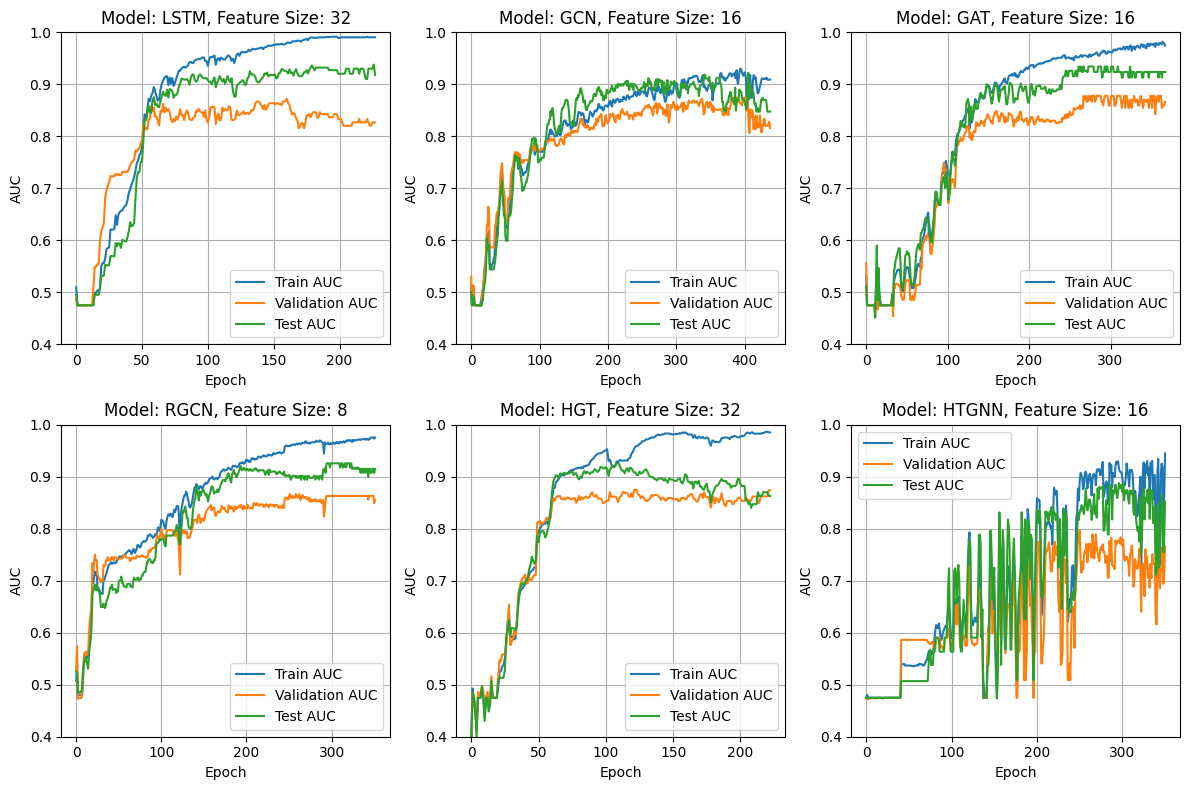

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Set names to those remaining in df
# "{dataset}-{model}-{feature_size}"
# Convert from categorical
df["Model"] = df["Model"].astype(str)
df["Name"] = df["Model"] + "-" + df["Feature Size"].astype(str)

for name, ax in zip(df["Name"], axs.flatten()):
    print(name)
    train_aucs = []
    val_aucs = []
    test_aucs = []
    for seed, data in seed_data[dataset + "-" + name].items():
        train_aucs.append(data["train_aucs"])
        val_aucs.append(data["val_aucs"])
        test_aucs.append(data["test_aucs"])
    model = seed_data[dataset + "-" + name][list(seed_data[dataset + "-" + name].keys())[0]]["model"]
    feature_size = seed_data[dataset + "-" + name][list(seed_data[dataset + "-" + name].keys())[0]]["feature_size"]
    # Calculate average of each list of lists.
    # If lists are of different size, only average remaining elements.
    def avg_variable_size_lists(lists):
        max_len = max([len(l) for l in lists])
        return np.mean(np.ma.masked_invalid([l + [np.nan] * (max_len - len(l)) for l in lists]), axis=0)
    train_aucs = avg_variable_size_lists(train_aucs)
    val_aucs = avg_variable_size_lists(val_aucs)
    test_aucs = avg_variable_size_lists(test_aucs)
    ax.plot(range(len(train_aucs)), train_aucs, label="Train AUC")
    ax.plot(range(len(val_aucs)), val_aucs, label="Validation AUC")
    ax.plot(range(len(test_aucs)), test_aucs, label="Test AUC")
    
    # Set the plot title and labels
    ax.set_title(f"Model: {model}, Feature Size: {feature_size}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("AUC")
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0.4, 1.0)

plt.tight_layout()
# Save in ../plots/Reddit-troll
plot_path = os.path.join("../../plots/Reddit-troll", "concatenated")
plt.savefig(plot_path + ".png", dpi=300)
# Save as pdf
plt.savefig(plot_path + ".pdf")

# Show the plot
plt.show()